Train: 13028, Val: 761, Test: 1527


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s] 


Epoch 1/8, Loss: 0.5854, Val Acc: 0.8778
Epoch 2/8, Loss: 0.3579, Val Acc: 0.8949
Epoch 3/8, Loss: 0.3020, Val Acc: 0.9028
Epoch 4/8, Loss: 0.2847, Val Acc: 0.9080
Epoch 5/8, Loss: 0.2689, Val Acc: 0.9185
Epoch 6/8, Loss: 0.2529, Val Acc: 0.9041
Epoch 7/8, Loss: 0.2464, Val Acc: 0.9172
Epoch 8/8, Loss: 0.2359, Val Acc: 0.9120
Training complete. Best Val Acc: 0.9185282522996058


/tmp/ipykernel_31/208946509.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.87      0.89      0.88       548
   PNEUMONIA       0.93      0.93      0.93       427
TUBERCULOSIS       0.91      0.88      0.89       417
     UNKNOWN       0.99      1.00      1.00       135

    accuracy                           0.91      1527
   macro avg       0.93      0.93      0.93      1527
weighted avg       0.91      0.91      0.91      1527

Confusion Matrix:
[[490  23  35   0]
 [ 26 398   3   0]
 [ 46   5 365   1]
 [  0   0   0 135]]


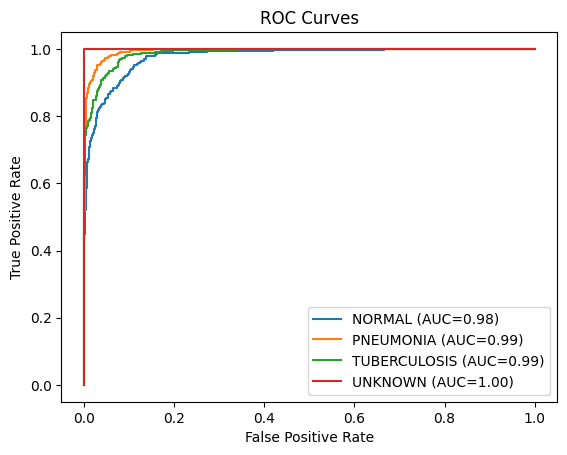

In [12]:
# Chest X-ray Multi-Class Classification: Pneumonia, Tuberculosis, Normal, Unknown (PyTorch, Kaggle Ready)

# 1. Imports & Setup
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# 2. Dataset Paths & Classes
DATA_DIR = "/kaggle/input/combined-unknown-pneumonia-and-tuberculosis/data"
CLASS_NAMES = ["NORMAL", "PNEUMONIA", "TUBERCULOSIS", "UNKNOWN"]
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}

def get_image_paths_and_labels(split):
    image_paths = []
    labels = []
    for cls in CLASS_NAMES:
        class_dir = os.path.join(DATA_DIR, split, cls)
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                image_paths.append(os.path.join(class_dir, fname))
                labels.append(CLASS_TO_IDX[cls])
    return image_paths, labels

train_paths, train_labels = get_image_paths_and_labels('train')
val_paths, val_labels = get_image_paths_and_labels('val')
test_paths, test_labels = get_image_paths_and_labels('test')

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

# 3. Dataset Class & Transforms
IMG_SIZE = 224
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class ChestXrayDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

train_ds = ChestXrayDataset(train_paths, train_labels, transform=train_transform)
val_ds = ChestXrayDataset(val_paths, val_labels, transform=val_transform)
test_ds = ChestXrayDataset(test_paths, test_labels, transform=val_transform)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

# 4. Model Definition (Transfer Learning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, len(CLASS_NAMES))
)
model = model.to(device)

# 5. Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)
num_epochs = 8

def train_model(model, criterion, optimizer, train_dl, val_dl, epochs):
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for imgs, labels in train_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_dl)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_dl:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
    print("Training complete. Best Val Acc:", best_acc)

# 6. Train the Model
train_model(model, criterion, optimizer, train_dl, val_dl, num_epochs)

# 7. Evaluation
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# 8. ROC-AUC for Each Class
probs = []
labels_list = []
with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(device)
        output = model(imgs)
        probs.extend(torch.softmax(output, dim=1).cpu().numpy())
        labels_list.extend(labels.numpy())
probs = np.array(probs)
labels_list = np.array(labels_list)
for i, class_name in enumerate(CLASS_NAMES):
    fpr, tpr, _ = roc_curve((labels_list == i).astype(int), probs[:, i])
    auc = roc_auc_score((labels_list == i).astype(int), probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_name} (AUC={auc:.2f})")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.show()

# 9. Save Final Model
torch.save(model.state_dict(), "final_model.pth")

In [ ]:
import torch

def get_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    return acc

# Example usage:
model.load_state_dict(torch.load("best_model.pth"))
accuracy = get_accuracy(model, test_dl, device)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

In [21]:
import torch
import numpy as np
import cv2
from PIL import Image

def generate_gradcam(model, img_tensor, class_idx):
    features = []
    gradients = []

    def forward_hook(module, input, output):
        features.append(output.cpu().data.numpy())

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].cpu().data.numpy())

    handle_fw = model.layer4.register_forward_hook(forward_hook)
    handle_bw = model.layer4.register_backward_hook(backward_hook)

    model.zero_grad()
    output = model(img_tensor)
    class_score = output[0, class_idx]
    class_score.backward()

    grads = gradients[0][0]
    fmap = features[0][0]
    weights = np.mean(grads, axis=(1, 2))
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i, :, :]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (img_tensor.shape[2], img_tensor.shape[3]))
    cam -= np.min(cam)
    cam /= np.max(cam) + 1e-8
    handle_fw.remove()
    handle_bw.remove()
    return cam

def overlay_cam_on_image(img: Image.Image, cam: np.ndarray, alpha=0.4) -> Image.Image:
    img = np.array(img.resize(cam.shape[::-1]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlayed = heatmap * alpha + img * (1 - alpha)
    overlayed = np.uint8(overlayed)
    return Image.fromarray(overlayed)